# Video Sentence Segmentation

The idea is to split the video into meaningful x-frame size windows. Each window should have enough metadata to represent a sign.

In [14]:
import csv
import os
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import scipy.spatial.distance
from scipy.signal import find_peaks
import time

import lesco as lsc

### load video files

In [15]:
# Load emergency situation videos.
root = r'C:\Users\XPC\Desktop\LESCO-oraciones'

files_ = []

for path, subdirs, files in os.walk(root):
    for name in files:
        class_name = os.path.basename(path)
        file_path = path + '\\' + name
        files_.append(file_path)
        
print(len(files_),"emergency videos detected")

21 emergency videos detected


In [16]:
video = files_[0]
print(video)

C:\Users\XPC\Desktop\LESCO-oraciones\bomberos_Estan quemando basura.mp4


### single video frame conversion to tensor

In [17]:
# PLAY VIDEO: they are burning trash
video_url = files_[0]
print(video_url)

font = cv.FONT_HERSHEY_SIMPLEX


video = []
count = 0
cap = cv.VideoCapture(video_url)
while cap.isOpened():
    
    ret, frame = cap.read()
    # if frame is read correctly ret is True
    if not ret:
        break
    frame = cv.resize(frame, (480,300), interpolation = cv.INTER_AREA)      
    
    # if there are hands in the frame, then add this to the tensor.
    if (lsc.has_hands(frame)):
        count = count + 1
        video.append(frame)
        cv.putText(frame, "frame: " + str(count) , (20, 50), font, 1, (45, 255, 0), 3)
        cv.imshow('frame', frame)
        time.sleep(0.3)
    
    if cv.waitKey(1) == ord('q'):
        break

cap.release()
cv.destroyAllWindows()

C:\Users\XPC\Desktop\LESCO-oraciones\bomberos_Estan quemando basura.mp4


### video segmentation

In [18]:
# similarity between images using Mean Squared Error
def mse_images(a,b):
    s = mean_squared_error(a,b)
    return s

def mae_images(a,b):
    s = mean_absolute_error(a,b)
    return s

def scc_images(a,b):
    s = scipy.spatial.distance.correlation(a,b)
    return s

cuts = []
buffer_size = 3
for i in range(0, len(video[:-buffer_size])):
    diff_1 = mse_images(video[i].flatten(), video[i+1].flatten())
    diff_2 = mse_images(video[i+1].flatten(), video[i+2].flatten())
    variation = abs(diff_1 - diff_2)
    if variation  <= 0.01:
        print("diff frames", i, i+1, i+2, diff_1, diff_2, variation)
        cuts.append(i)

print("proposed video cuts:", cuts)

diff frames 24 25 26 6.185553240740741 6.190486111111111 0.004932870370370601
diff frames 88 89 90 3.584974537037037 3.5844953703703704 0.00047916666666658614
diff frames 108 109 110 1.3771875 1.3695462962962963 0.007641203703703692
diff frames 250 251 252 1.6292685185185185 1.630212962962963 0.0009444444444444144
proposed video cuts: [24, 88, 108, 250]


In [19]:
window_size = 50
for cut in cuts:
    cap = cv.VideoCapture(video_url)
    count = 0
    print("Displaying cut:", cut)
    while cap.isOpened():

        ret, frame = cap.read()
        # if frame is read correctly ret is True
        if not ret:
            break
        frame = cv.resize(frame, (480,300), interpolation = cv.INTER_AREA)      
        
        if (count >= cut and count <= cut + window_size):
            cv.imshow('frame', frame)

        if cv.waitKey(1) == ord('q'):
            break
            
        count = count + 1
        
    cap.release()
    cv.destroyAllWindows()
    print("Completed")


Displaying cut: 24
Completed
Displaying cut: 88
Completed
Displaying cut: 108
Completed
Displaying cut: 250
Completed


Displaying Cut: 24


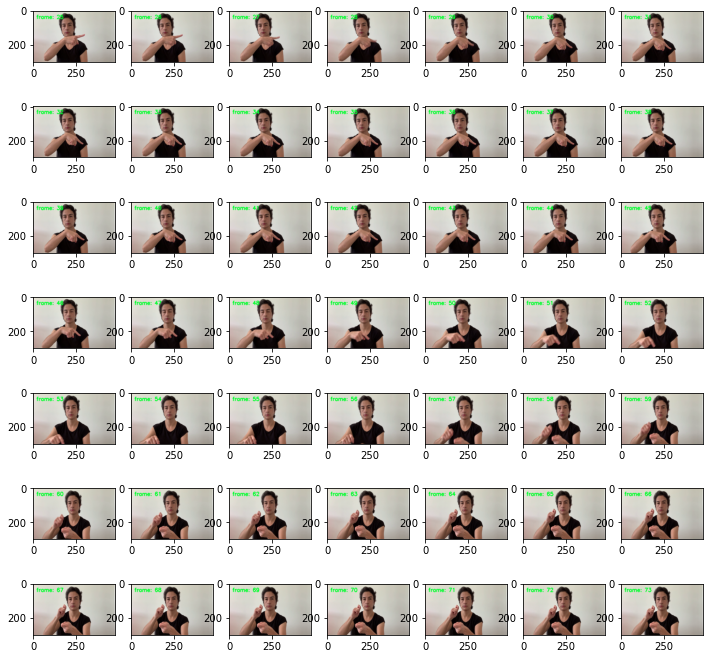

 
 
Displaying Cut: 88


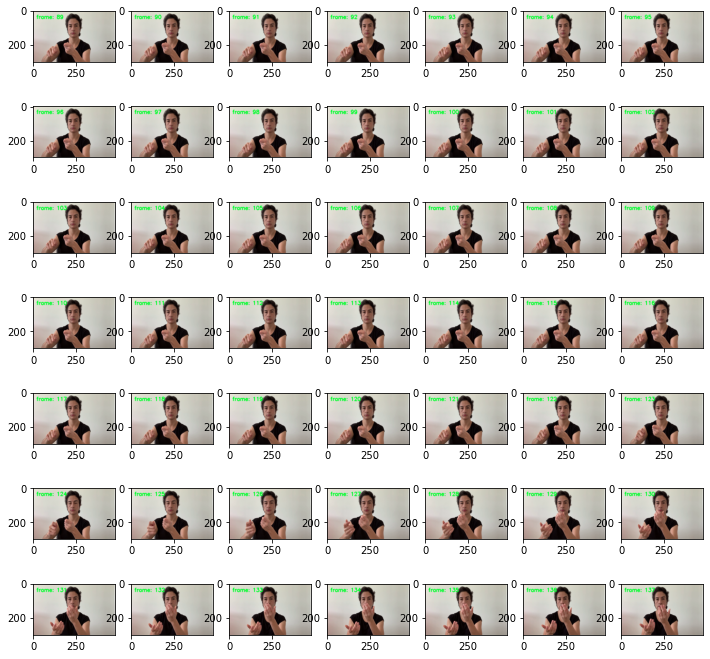

 
 
Displaying Cut: 108


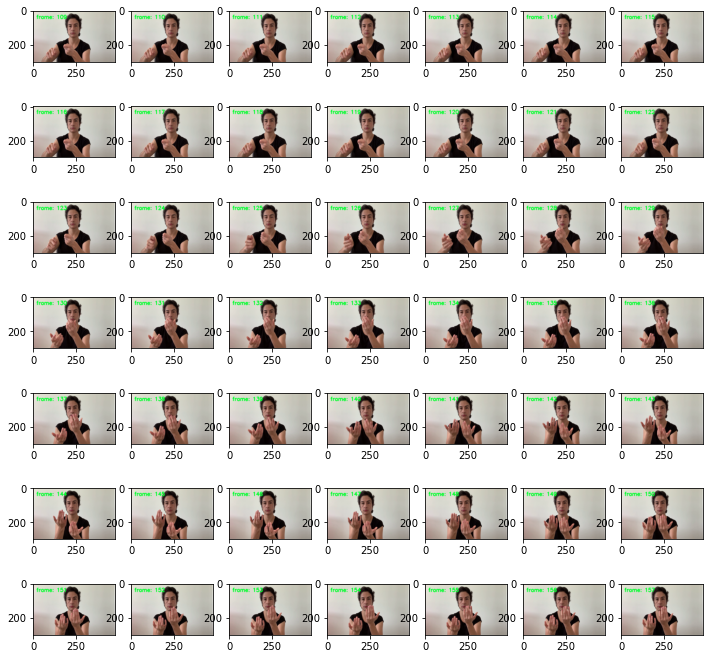

 
 
Displaying Cut: 250


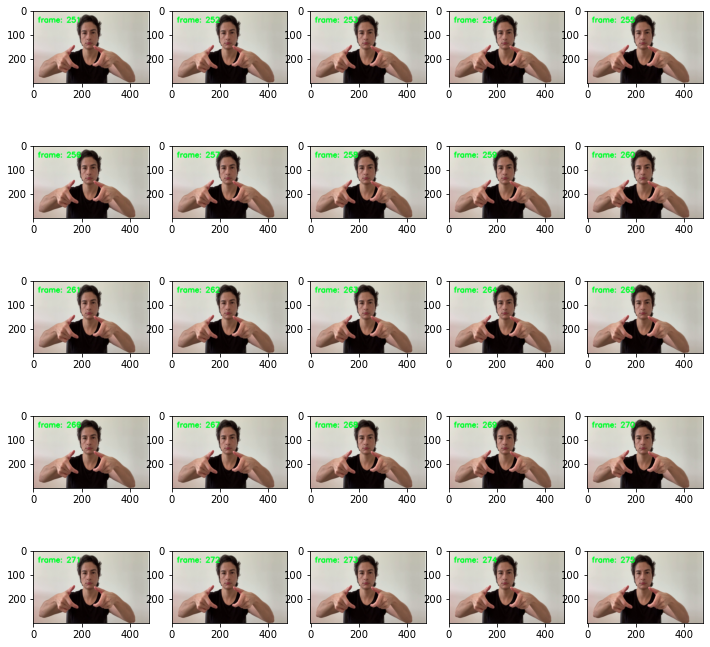

In [20]:
for cut in cuts:
    count = len(video[cut:cut+50])
    n_row = int(math.sqrt(count))
    n_col = int(math.sqrt(count))

    print("Displaying Cut:", cut)
    _, axs = plt.subplots(n_row, n_col, figsize=(12, 12))
    axs = axs.flatten()
    for img, ax in zip(video[cut:cut+50], axs):
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        ax.imshow(img)
    plt.show()
    print(" ")
    print(" ")

## algorithm for segmentation

In [21]:
# similarity between images using Mean Squared Error
def mse_images(a,b):
    s = mean_squared_error(a,b)
    return s

def video_segmentation(video_url, window_size, seg_threshold):
    
    # Load video and frames with hands.
    video = []
    count = 0
    cap = cv.VideoCapture(video_url)
    while cap.isOpened():

        ret, frame = cap.read()
        # if frame is read correctly ret is True
        if not ret:
            break
        
        # reduce image size for speed
        frame = cv.resize(frame, (480,300), interpolation = cv.INTER_AREA)      

        # if there are hands in the frame, then add this to the tensor.
        if (lsc.has_hands(frame)):
            video.append(frame)

        if cv.waitKey(1) == ord('q'):
            break

    cap.release()
    cv.destroyAllWindows()
    
    # create video cuts based on the mse
    cuts = []
    buffer_size = 3
    for i in range(0, len(video[:-buffer_size])):
        diff_1 = mse_images(video[i].flatten(), video[i+1].flatten())
        diff_2 = mse_images(video[i+1].flatten(), video[i+2].flatten())
        variation = abs(diff_1 - diff_2)
        if variation  <= seg_threshold:
            print("diff frames", i, i+1, i+2, diff_1, diff_2, variation)
            cuts.append(i)
    
    # create a tensor just of the important moments.
    video_tensor = []
    for cut in cuts:
        video_tensor.append(video[cut:cut+window_size])
    
    return video_tensor


In [22]:
import cv2 as cv
import lesco as lsc
from sklearn.metrics import mean_squared_error

video_url = r'C:\Users\XPC\Desktop\LESCO-oraciones\bomberos_Estan quemando basura.mp4'
window_size = 50

segmented_video = video_segmentation(video_url, window_size, 0.01)

diff frames 14 15 16 5.9941203703703705 6.0034930555555555 0.00937268518518497
diff frames 69 70 71 3.5068333333333332 3.5052314814814816 0.0016018518518516878
diff frames 216 217 218 2.8279074074074075 2.8254236111111113 0.002483796296296248
diff frames 247 248 249 1.6357407407407407 1.6296597222222222 0.0060810185185184995


In [23]:
len(segmented_video)

4